# Chest X-Ray Images (Pneumonia)
Author : Christophe Marabotto

Dataset : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Paper source : http://downloads.hindawi.com/journals/jhe/2019/4180949.pdf

In [19]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from glob import glob


from keras.preprocessing.image import load_img

In [20]:
# Base directory
data_path = "/Users/cmarabotto/OneDrive - EPITA/PROJETS/Chest X-Ray Images (Pneumonia)/chest_xray"

# Sets
train_path = data_path +  "/train"
normal_train_path = train_path + "/NORMAL"
pneumonia_train_path = train_path + "/PNEUMONIA"


val_path = data_path + "/val"
normal_val_path = val_path + "/NORMAL"
pneumonia_val_path = val_path + "/PNEUMONIA"

test_path = data_path + "/test"
normal_test_path = test_path + "/NORMAL"
pneumonia_test_path = test_path + "/PNEUMONIA"

In [21]:
# Images
normal_train_paths = glob(normal_train_path + "/*.jpeg")
pneumonia_train_paths = glob(pneumonia_train_path + "/*.jpeg")

normal_val_paths = glob(normal_val_path + "/*.jpeg")
pneumonia_val_paths = glob(pneumonia_val_path + "/*.jpeg")

normal_test_paths = glob(normal_test_path + "/*.jpeg")
pneumonia_test_paths = glob(pneumonia_test_path + "/*.jpeg")

# I. Data exploration

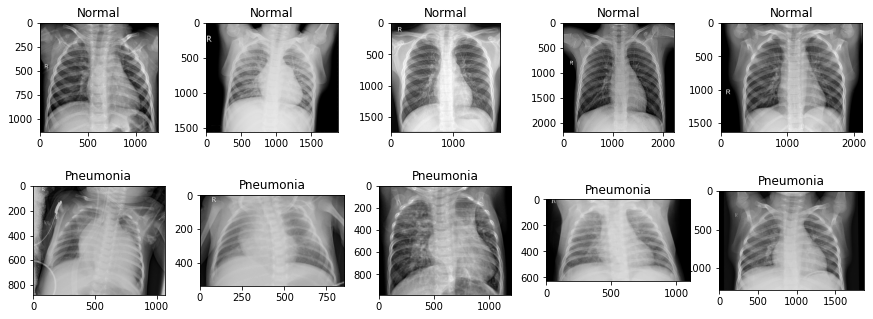

In [22]:
# Visualize a random sample (5 normal / 5 Pneumonian, training set)
plt.figure(figsize=(15, 5))

for k in range (0, 5):
    plt.subplot(2, 5, k + 1)
    plt.title("Normal")
    img = np.asarray(plt.imread(normal_train_paths[np.random.randint(len(normal_train_paths))]))
    plt.imshow(img, cmap="gray")

for k in range (0, 5):
    plt.subplot(2, 5, k + 6)
    plt.title("Pneumonia")
    img = np.asarray(plt.imread(pneumonia_train_paths[np.random.randint(len(pneumonia_train_paths))]))
    plt.imshow(img, cmap="gray")

plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()

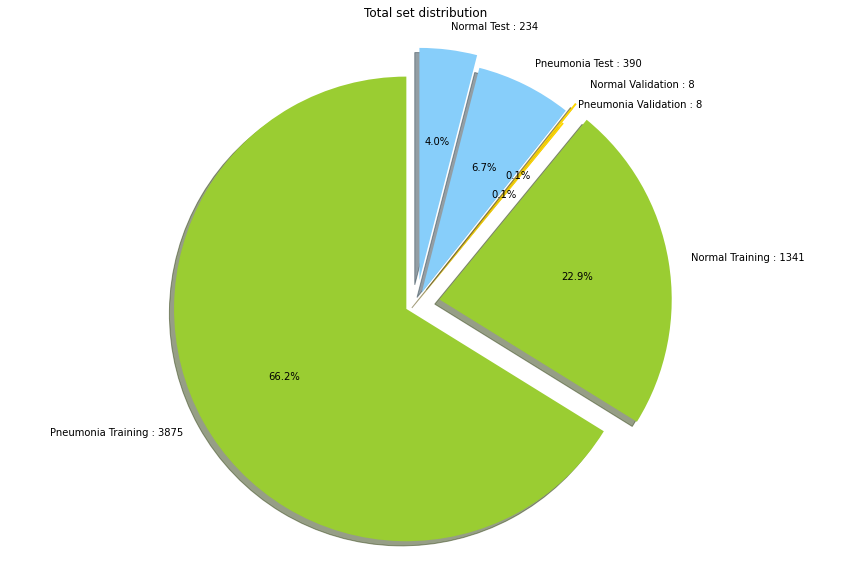

In [23]:
# Répartition des sets, diagramme circulaire (pie)
plt.figure(figsize=(15, 10))
labels = 'Pneumonia Training : ' + str(len(pneumonia_train_paths)), 'Normal Training : ' + str(len(normal_train_paths)), 'Pneumonia Validation : ' + str(len(pneumonia_val_paths)), 'Normal Validation : ' + str(len(normal_val_paths)), 'Pneumonia Test : ' + str(len(pneumonia_test_paths)), 'Normal Test : ' + str(len(normal_test_paths))
sizes = [len(pneumonia_train_paths), len(normal_train_paths),
         len(pneumonia_val_paths), len(normal_val_paths),
         len(pneumonia_test_paths), len(normal_test_paths)]
colors = ['yellowgreen', 'yellowgreen', 'gold', 'gold', 'lightskyblue', 'lightskyblue']
explode = (0.05, 0.1, 0, 0.1, 0.05, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')


plt.pie(sizes, labels=labels, colors=colors, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.title("Total set distribution")
plt.axis('equal')

plt.show()

# II. Preprocessing

In [24]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, load_img

In [25]:
"""
ImageDataGenerator : generate batches of tensor image data with real-time data augmentation. 
The data will be looped over (in batches).
rescale: rescaling factor. Defaults to None. If None or 0, no rescaling is applied, 
        otherwise we multiply the data by the value provided (after applying all other transformations).
shear_range: Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
zoom_range: Float or [lower, upper]. Range for random zoom. 
            If a float, [lower, upper] = [1-zoom_range, 1+zoom_range].$
horizontal_flip: Boolean. Randomly flip inputs horizontally.
"""

# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

"""
directory: path where your 'n' classes of folders are present.
target_size : size of your input images, every image will be resized to this size.
batch_size: Nb of images to be yielded from the generator per batch
color_mode: if the image is either black and white or grayscale set “grayscale” 
            or if the image has three color channels, set “rgb”.
class_mode: Set “binary” if you have only two classes to predict, 
            if not set to “categorical”, in case if you’re developing an Autoencoder system, 
            both input and the output would probably be the same image, for this case set to “input”
shuffle: Set True if you want to shuffle the order of the image that is being yielded, else set False.
"""
training_set = train_datagen.flow_from_directory(directory = train_path,
                                                 target_size = (200, 200),
                                                 batch_size = 32,
                                                 class_mode = 'binary',
                                                 shuffle=False) 

validation_generator = val_datagen.flow_from_directory(directory = val_path,
                                                        target_size=(200, 200),
                                                        batch_size=32,
                                                        class_mode='binary',
                                                        shuffle=False)

datagen = ImageDataGenerator(rescale = 1./255)
test_set = datagen.flow_from_directory(directory = test_path,
                                       target_size = (200, 200),
                                       class_mode = 'binary',
                                       shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# III. Training

In [90]:
# CNN architecture
model = Sequential()

#1 Convolutional layer
"""
The Conv2D function is taking 4 arguments, 
the first is the number of filters (32 here), 
the second argument is the shape each filter is going to be (3x3 here), 
the third is the input shape and the type of image(RGB or Black and White) of each image
the input image our CNN is going to be taking is of a 64x64 resolution and “3” stands for RGB, 
Problem: image with different shapes => 
    For a RGB dataset
        inp = Input(shape=(None,None, 3))
    
    For a Gray dataset
        inp = Input(shape=(None,None, 1))

the fourth argument is the activation function we want to use, here ‘relu’ stands for a rectifier function.
"""
model.add(Conv2D(32, (3, 3), input_shape = (200, 200, 3), activation = 'relu'))


#2 Pooling layer
"""
The primary aim of a pooling operation is to reduce the size of the images as much as possible.
(we are trying to reduce the total number of nodes for the upcoming layers.)
We take a 2x2 matrix we’ll have minimum pixel loss and get a precise region where the feature are located.
"""
model.add(MaxPooling2D(pool_size = (2, 2)))


#3 Adding a second convolutional layer
model.add(Conv2D(64, (3, 3), activation="relu"))

#4 Pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))


#5 Convolutional layer
model.add(Conv2D(128, (3, 3), activation="relu"))

#6 Pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))

#7 Convolutional layer
model.add(Conv2D(128, (3, 3), activation="relu"))

#8 Pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))


#9 Flatten the layer
model.add(Flatten())

#10 Dropout
model.add(Dropout(0.5))

#7 Fully Connected Layers
"""
Dense is the function to add a fully connected layer, 
'units' is where we define the number of nodes that should be present in this hidden layer
"""
model.add(Dense(activation = 'relu', units = 512))
"""
Sigmoid is used for binary classification
0: Normal ; 1: Pneumonia 
"""
model.add(Dense(activation = 'sigmoid', units = 1))

#7 Compile the Neural network
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 128)      

In [ ]:
"""
steps_per_epoch: Integer or None. Total number of steps (batches of samples) before declaring one 
                 epoch finished and starting the next epoch. When training with input tensors such as 
                 TensorFlow data tensors, the default None is equal to the number of samples in your 
                 dataset divided by the batch size, or 1 if that cannot be determined.
                 
validation_steps: Only relevant if steps_per_epoch is specified. 
                  Total number of steps (batches of samples) to validate before stopping.
                  Only relevant if validation_data is provided and is a generator. 
                  Total number of steps (batches of samples) to draw before stopping when 
                  performing validation at the end of every epoch.

steps_per_epoch = 163 =
validation_steps = 624 = size of the testing set (normal + pneumania)

"""

# Simple early stopping : stop training when validation loss start increasing
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

model_hist = model.fit_generator(training_set,
                         epochs = 60,
                         validation_data = validation_generator,
                         steps_per_epoch = 163,
                         validation_steps = 624) # callbacks=[es] to enable early stopping

history = model_hist.history

In [ ]:
# Display
fig = plt.figure(1, figsize=(15, 10))
plt.style.use("default")
plt.grid()
plt.plot(history['loss'])
plt.plot(history['accuracy'])
plt.plot(history['val_loss'])
plt.plot(history['val_accuracy'])

plt.title('Training')
plt.xlabel('Epoch')
plt.legend(["loss", "accuracy", "val_loss", "val_accuracy"], loc="upper right")
plt.savefig("Training")

plt.show()

In [71]:
# Saving model
model.save("model.h5")
model.save_weights("model_weights.h5")

## III. Test

## IV. Result analysis

In [26]:
# Loading existing model
from keras.models import load_model

model = load_model('model.h5')
model.load_weights("model_weights.h5")

In [27]:
test_loss, test_acc = model.evaluate_generator(test_set)
print("Testing loss :", test_loss, "Testing accuracy :", test_acc)

Testing loss : 0.06997430324554443 Testing accuracy : 0.8990384340286255


In [28]:
prediction = model.predict_generator(test_set)

In [30]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

y_true = test_set.classes
y_pred = np.where(prediction > 0.5, 1, 0)

num_values = len(y_true)
print("Number of observations: {}".format(num_values))

# Calculate Precision
# The precision is the ratio tp / (tp + fp)
precision = precision_score(y_true, y_pred)
print("Precision Score: {}".format(precision))

# Calculate Recall
# The recall is the ratio tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print("Recall Score: {}".format(recall))

# Calculate Accuracy
# The accuracy is the ratio (TP + TN)/(TP + TN + FP + FN)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy Score: {}".format(accuracy))

# Calculate the number of positive predictions
num_pos_preds = accuracy * num_values
num_neg_preds = num_values - num_pos_preds
print("Number of Positive Predictions: {0} \n"
      "Number of Negative Predictions: {1}".format(num_pos_preds, num_neg_preds))

# Calculate the False Negatives
FN = num_pos_preds * (1 - recall)
print("FN: {0}".format(FN))

# Calculate the True Positives
TP = num_pos_preds - FN
print("TP: {0}".format(TP))

# Calculate the True Negatives
TN = num_pos_preds - TP
print("TN: {0}".format(TN))

# Calculate the False Positives
FP = num_neg_preds - TN
print("FP: {0}".format(FP))


Number of observations: 624
Precision Score: 0.9246753246753247
Recall Score: 0.9128205128205128
Accuracy Score: 0.8990384615384616
Number of Positive Predictions: 561.0 
Number of Negative Predictions: 63.0
FN: 48.90769230769232
TP: 512.0923076923077
TN: 48.90769230769229
FP: 14.092307692307713


[[205  29]
 [ 34 356]]
Precision: 0.8990384615384616


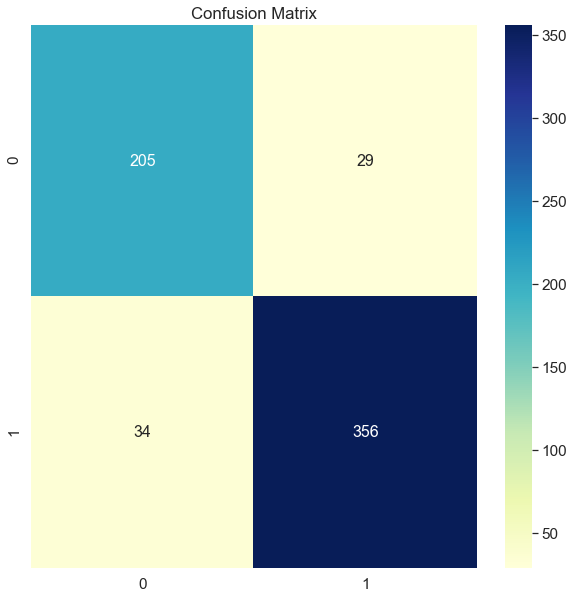

In [33]:
# Matrice de confusion
"""
confusion_matrix(y_true, y_pred)
Ex:

y_true = [1,0,0]
y_pred = [1,0,0]
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

Result example:
array([[True Negative,   False Positive],
       [False Negative,   True Positive]])
"""
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

print("Precision:", (conf_mat[0][0] + conf_mat[1][1])/(conf_mat[0][0] + conf_mat[0][1] + conf_mat[1][0] + conf_mat[1][1]))

# Pretty printing
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
 
array = conf_mat.tolist()

cm_df = pd.DataFrame(array, range(2), range(2))
plt.figure(figsize=(10,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm_df, annot=True, annot_kws={"size": 16}, fmt="d", cmap="YlGnBu") # font size


plt.title("Confusion Matrix")
plt.show()

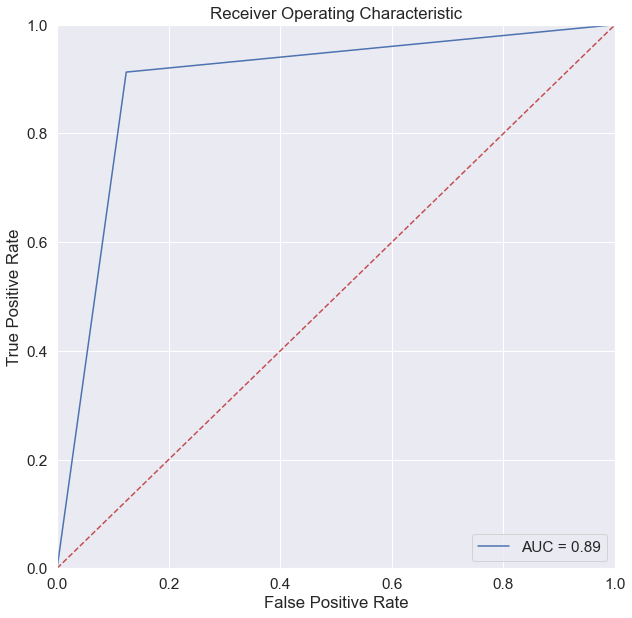

In [32]:
# Courbe ROC
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

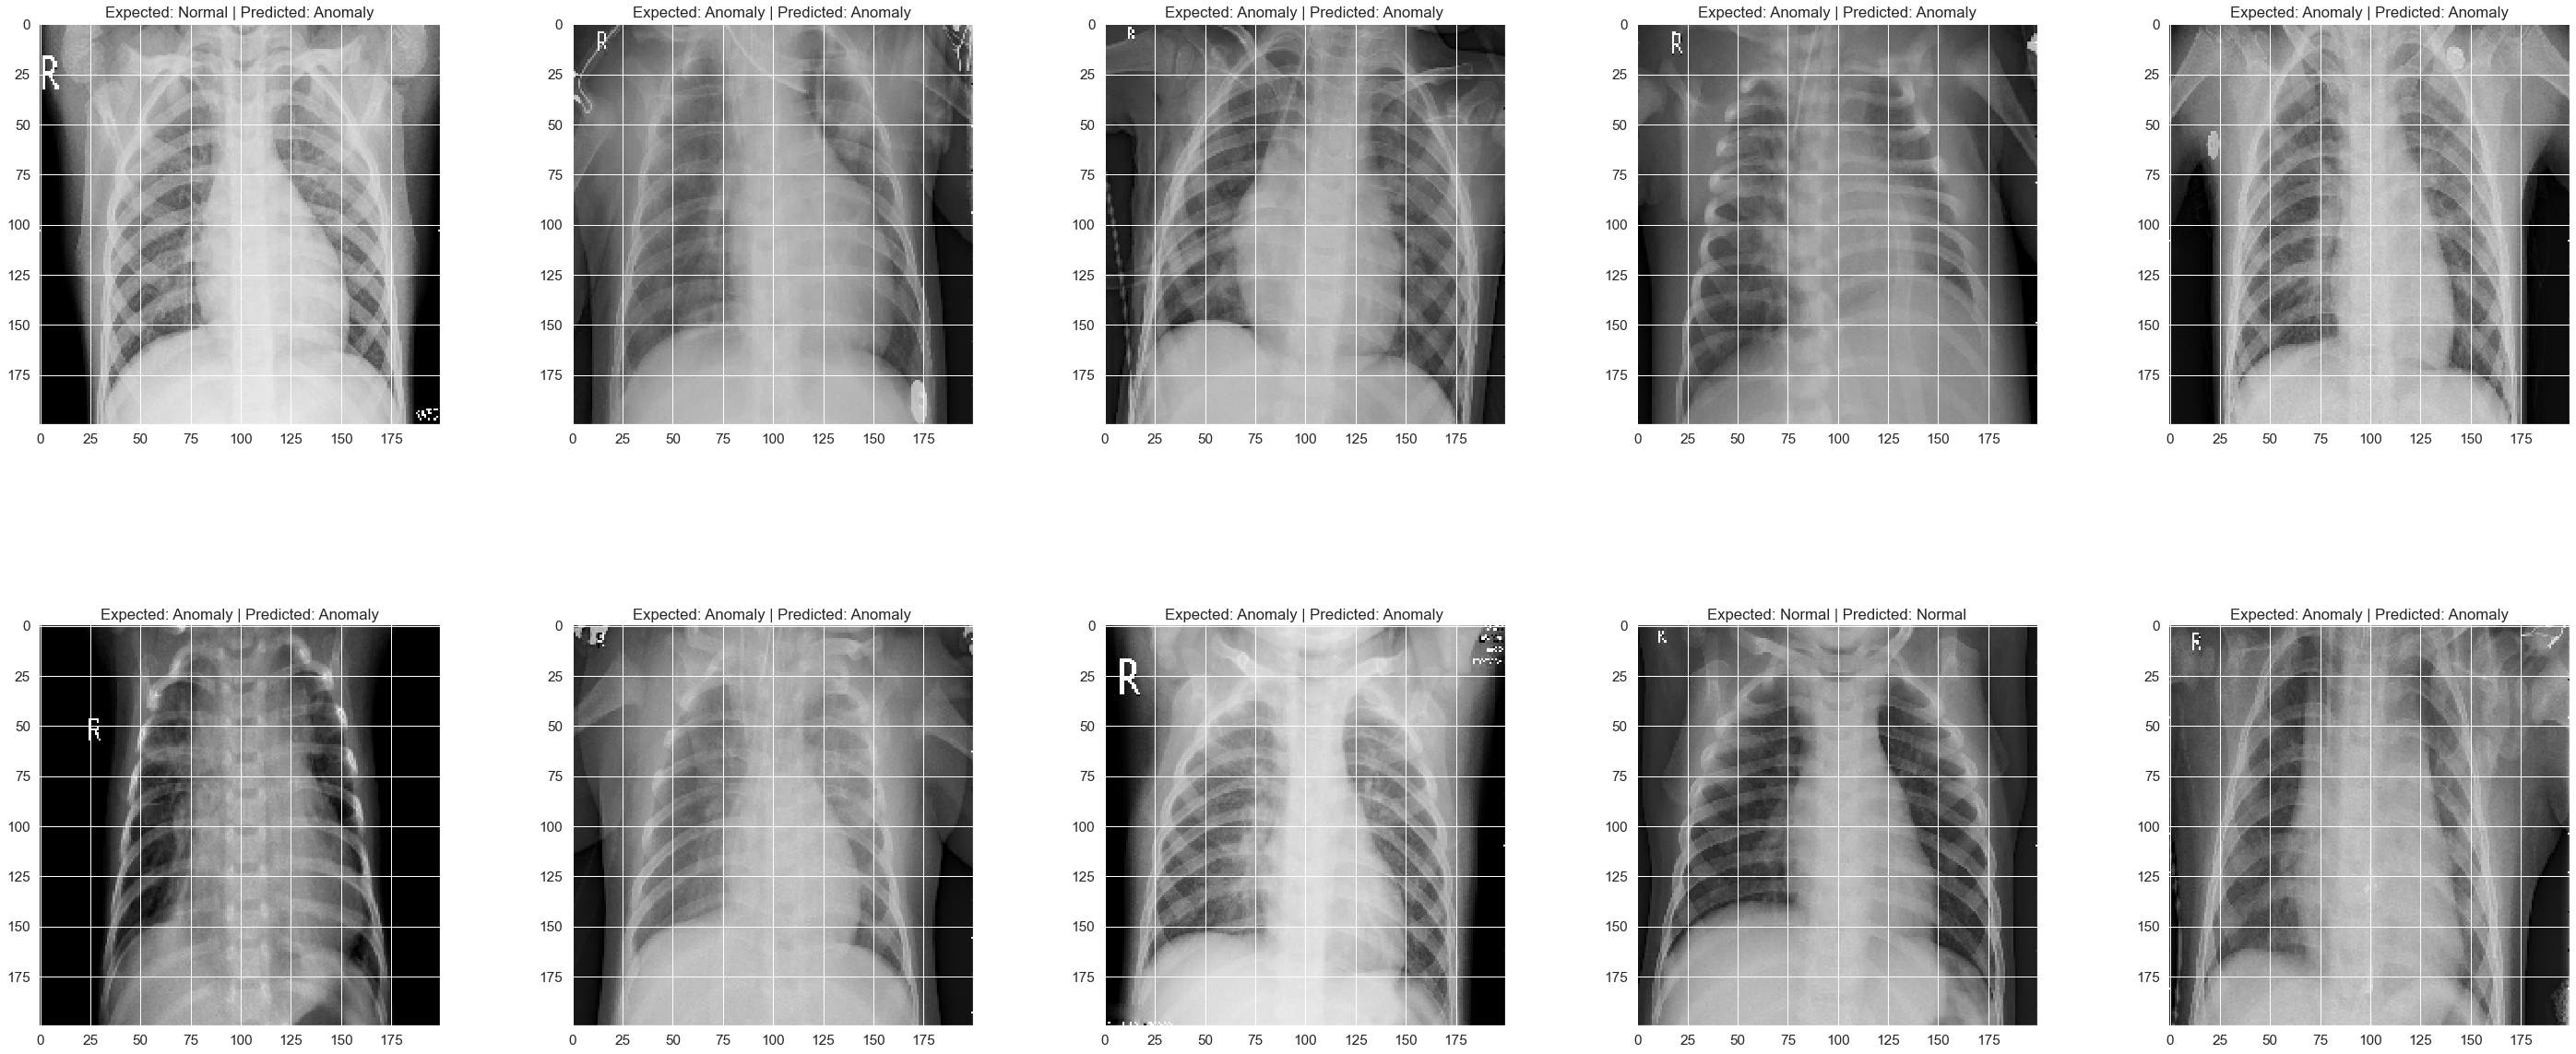

In [132]:
# Visualize a random prediction sample (5 cases)
plt.figure(figsize=(50, 20))

exp = np.where(test_set.classes > 0.5, "Anomaly", "Normal").flatten()
pred = np.where(prediction > 0.5, "Anomaly", "Normal").flatten()


for k in range (10):
    plt.subplot(2, 5, k + 1)
    case = np.random.randint(len(pred))
    plt.gray()
    title = "Expected: " + str(exp[case]) + " | Predicted: " + str(pred[case])
    plt.title(title)
    plt.imshow(test_set[case][0][0], interpolation="nearest")
    

    
plt.subplots_adjust(hspace=0.5, wspace=0.2)
plt.show()